In [1]:
import os, shutil
import matplotlib.pyplot as plt
import numpy as np

# visualization libraries
from PIL import Image
from keras.utils import plot_model
from IPython.display import Image 

# preprocessing
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# modelling
import keras
import tensorflow as tf
from keras import layers
from keras import models
from keras import utils
from keras import optimizers
from keras.models import Sequential
from keras.losses import categorical_crossentropy, binary_crossentropy
from keras.optimizers import SGD, Adam
# from keras.applications.vgg19 import VGG19
from keras import losses
from keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
import math 

# callbacks
from keras.callbacks import History


# Surpress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#access directories through Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
np.random.seed(0)
root_dir = "/content/gdrive/My Drive/Colab Notebooks/pneumonal_xray_classification/chest_xray/"

## Importing & Exploring Data

In [4]:
train_folder = os.path.join(root_dir, 'train')
test_folder = os.path.join(root_dir, 'test')
val_folder = os.path.join(root_dir, 'val')

In [5]:
# train_datagen = ImageDataGenerator(
#         rescale=1./255,
#         shear_range=0.2,
#         zoom_range=0.3,
#         rotation_range=15,
#         horizontal_flip=True,
#         vertical_flip=True,
#         #validation_split = 0.2
# )

# get all the data in the directory /train and reshape them
train_generator = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.3,
        rotation_range=15,
        horizontal_flip=True,
        vertical_flip=True,
        #validation_split = 0.2
 ).flow_from_directory(
        train_folder, 
        target_size=(256, 256), 
        batch_size=1000)
 
# get all the data in the directory /test and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(256, 256), 
        batch_size = 200) 

# get all the data in the directory /val and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(256, 256), 
        batch_size = 16)


Found 2713 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [6]:
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

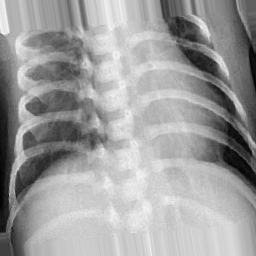

In [7]:
#preview training image
array_to_img(train_images[1])

In [8]:
#preview training image
# array_to_img(train_images[104])

In [9]:
# get shape of images in train and test

print(np.shape(train_images))
print(np.shape(train_labels))
print(np.shape(test_images))
print(np.shape(test_labels))


(1000, 256, 256, 3)
(1000, 2)
(200, 256, 256, 3)
(200, 2)


All images share the same dimensions, so we don't have to worry about losing any additional information by transforming and resizing the images to fit. We can go directly into refitting the test and training images from tensors to a single vectors for training, test, and validation purposes.

In [10]:
# reshape images to contain dimensions into a single vector
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(1000, 196608)
(200, 196608)
(16, 196608)


In [11]:
# reshape images to contain dimensions into a single vector
train_y = np.reshape(train_labels[:,0], (1000,1))
test_y = np.reshape(test_labels[:,0], (200,1))
val_y = np.reshape(val_labels[:,0], (16,1))

Now that we've cleaned the data and reshaped the dimensions to fit into individual vectors, we can move on to identifying the existing labels for your test and training images. Ideally, we'll find a binary classification that classified images as "Normal"or as "Pneumonia". If any other labels exists, we can examine the data.

If a third label exists, we will further examine whether or not those labels include pneumonial examples that work for the purposes of this model.

In [12]:
#preview label to identify class valujes
train_labels

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [13]:
#identify the categorical values of 0 and 1
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [14]:
train_labels_final = train_labels.T[[1]]
np.shape(train_labels_final)

(1, 1000)

In [15]:
test_labels_final = test_labels.T[[1]]
np.shape(test_labels_final)


(1, 200)

In [16]:
# array_to_img(train_images[135])


In [17]:
# train_labels_final[:,135]

Recap: We've now idenitified our two categories: Normal and Pneumonia, represented by 0 and 1, respectively. Our images were successfully resized and ready to go through our base model. We double checked that all of our training and testing images fit the our categorical labels and there's no extraneous categories that might skew the model results.

## CNN Model

In [18]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(256 , 256,  3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Dropout(.2))
model.add(layers.Conv2D(32, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(.2))
model.add(layers.Flatten())
# model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 32)      16416     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 62, 62, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 123008)            0

In [19]:
history = model.fit(train_images,
                    train_y,
                    epochs=10,
                    batch_size=100,
                    validation_data=(val_images, val_y))

Epoch 1/10
10/10 [==============================] - 42s 4s/step - loss: 1.0275 - acc: 0.5090 - val_loss: 0.6909 - val_acc: 0.6250
Epoch 2/10
10/10 [==============================] - 42s 4s/step - loss: 0.6897 - acc: 0.5470 - val_loss: 0.6898 - val_acc: 0.6875
Epoch 3/10
10/10 [==============================] - 42s 4s/step - loss: 0.6787 - acc: 0.6150 - val_loss: 0.6871 - val_acc: 0.6875
Epoch 4/10
10/10 [==============================] - 42s 4s/step - loss: 0.6671 - acc: 0.6220 - val_loss: 0.6831 - val_acc: 0.5000
Epoch 5/10
10/10 [==============================] - 42s 4s/step - loss: 0.6964 - acc: 0.5810 - val_loss: 0.6863 - val_acc: 0.5000
Epoch 6/10
10/10 [==============================] - 41s 4s/step - loss: 0.6510 - acc: 0.6670 - val_loss: 0.6752 - val_acc: 0.6250
Epoch 7/10
10/10 [==============================] - 42s 4s/step - loss: 0.6238 - acc: 0.6900 - val_loss: 0.6652 - val_acc: 0.5625
Epoch 8/10
10/10 [==============================] - 42s 4s/step - loss: 0.6002 - acc: 0.65

In [20]:
results_train = model.evaluate(train_images, train_y)

32/32 [==============================] - 11s 350ms/step - loss: 0.6057 - acc: 0.8180


In [21]:
results_test = model.evaluate(test_images, test_y)

7/7 [==============================] - 2s 277ms/step - loss: 0.6086 - acc: 0.7700


In [22]:
results_train

[0.6057247519493103, 0.8180000185966492]

In [23]:
results_test

[0.6085917949676514, 0.7699999809265137]

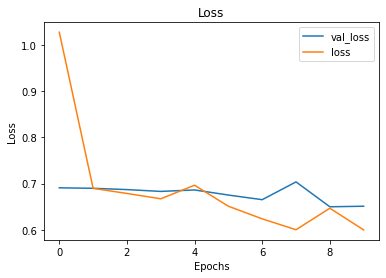

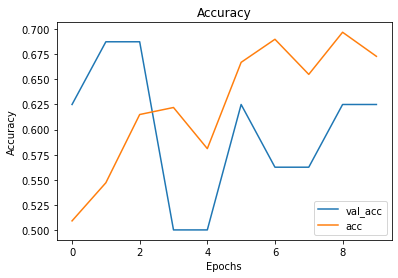

In [24]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

visualize_training_results(history)

In [25]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(test_images, batch_size=64)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(test_y, y_pred_bool))

              precision    recall  f1-score   support

         0.0       0.57      1.00      0.73       114
         1.0       0.00      0.00      0.00        86

    accuracy                           0.57       200
   macro avg       0.28      0.50      0.36       200
weighted avg       0.32      0.57      0.41       200



In [26]:
confusion_matrix(test_y, y_pred_bool)

array([[114,   0],
       [ 86,   0]])

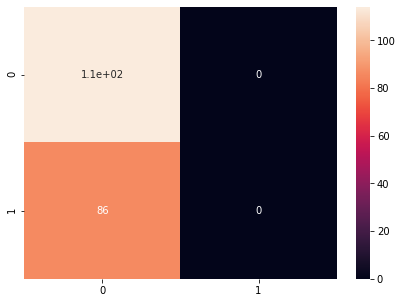

In [27]:
import pandas as pd
import seaborn as sns

confusion_matrix_df = pd.DataFrame(confusion_matrix(test_y, y_pred_bool)).rename(columns=train_generator.class_indices, index=train_generator.class_indices)
fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)

We saw an increase in accuracy in our training results, now with a 98% accuracy and .058 loss, but we saw no change in our test results. Judging by our visualizations, however, we did see that our model more gradually improved at testing went on (up to 20 epochs), in comparison to our previous models. Instead of sharp increases and maximum plateaus, we saw more gradual increases with plateaus in accuracy occuring in decreases of accuracy verus increases.

## Conclusion

Through all of our models, we saw minimum increases in test models, even though we did maintain a 4-6% increase in accuracy outside of our base model. While the results didn't change much, the visualizations did give us some insight on what happened in the model. Each of the non-CNN models hit a repeated ceiling in accuracy where the results plateaued for a few epochs befor a signfinicant drop, mirrored by a sigificant increase in error rate. The CNN model showed more gradual increases in the testing model results, versus the steep increases in accuracy followed by a plateau and steep drops we saw earlier.

Whether or not this accuracy plateau was due to the data quality, sample sizes, or issues in how the models were created is unknown. Trying additional CNN methods might help address this issue so we can produce more accurate results